In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import minimize

读取训练集 /
Load the training dataset

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
print(f'训练集维度 / train shape:{train.shape}\n')

print('训练集概况 / train info:')
print(train.info())

print('训练集特征统计 / train statistics:')
display(train.describe())

print('\n训练集前五行数据展示 / preview of first 5 training rows:')
display(train.head())

训练集维度 / train shape:(750000, 9)

训练集概况 / train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None
训练集特征统计 / train statistics:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000



训练集前五行数据展示 / preview of first 5 training rows:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


读取测试集
load the test dataset

In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
print(f'测试集维度 / test shape:{test.shape}\n')

print('测试集概况 / test info:')
print(test.info())

print('测试集特征统计 / test statistics:')
display(test.describe())

print('\n测试集前五行数据展示 / preview of first 5 test rows:')
display(test.head())

测试集维度 / test shape:(250000, 8)

测试集概况 / test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB
None
测试集特征统计 / test statistics:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,41.452464,174.725624,75.147712,15.415428,95.479084,40.036093
std,72168.927986,15.177769,12.822039,13.979513,8.349133,9.450161,0.778448
min,750000.000000,20.000000,127.000000,39.000000,1.000000,67.000000,37.100000
25%,812499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000
50%,874999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000
75%,937499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.600000
max,999999.000000,79.000000,219.000000,126.000000,30.000000,128.000000,41.500000



测试集前五行数据展示 / preview of first 5 test rows:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


编码处理 /
Coding categorical features

In [5]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

可视化特征 /
Visualize features

KeyboardInterrupt: 

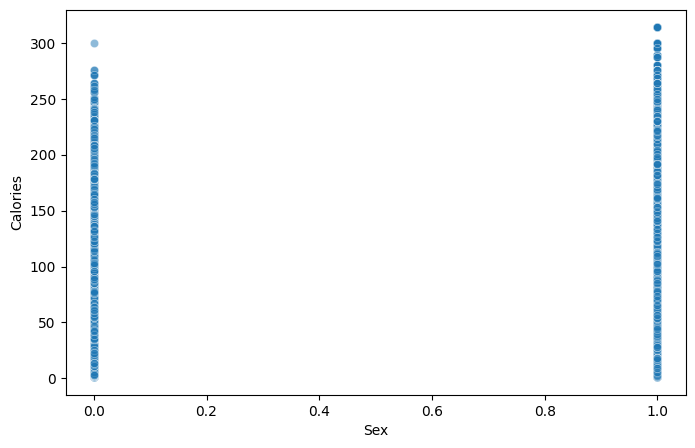

In [6]:
# 绘制各个特征与Calories的散点图
# Scatter plot between each feature and Calories
old_features = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# 去掉Calories，避免与它自己画图 
# Exclude Calories to aviod plotting it against itself
for feature in old_features[:-1]:   
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=train[feature], y=train['Calories'], alpha=0.5)
    sns.regplot(x=train[feature], y=train['Calories'], scatter=False, color='red')
    plt.title(f'{feature} vs. Calories')
    plt.xlabel(feature)
    plt.ylabel('Calories')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# 绘制特征相关热力图
# Plot feature correlation heatmsp
plt.figure(figsize=(7, 6))
sns.heatmap(train[old_features[1:]].corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('feature heatmap')
plt.show()

In [ ]:
# 绘制Sex和Calories的箱型图
# Box plot of Sex vs. Calories
plt.figure(figsize=(7, 6))
sns.boxplot(x='Sex', y='Calories', data=train)
plt.title('Sex vs. Calories')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 绘制Calories的KDE图
# KDE plot for Calories
plt.figure(figsize=(6, 5))
sns.kdeplot(train['Calories'], shade=True, color='purple')
plt.title('Calories KDE')
plt.xlabel('Calories')
plt.ylabel('density')
plt.grid(True)
plt.tight_layout()
plt.show()

特征预处理和数据集划分 /
Feature preprocessing and dataset split

In [7]:
features = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
           
X = train[features]
y = np.log1p(train['Calories'])   # 标签对数转换 / Log transform the target variable
X_test = test[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

寻找XGB最优参数 /
Search for optimal XGB parameters

In [8]:
# xgb = XGBRegressor(random_state=42)

# param_grid = {
#     'n_estimators': [500, 1000],
#     'learning_rate': [0.01, 0.05],
#     'max_depth': [3, 5],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
#                            cv=3,scoring='neg_root_mean_squared_error', verbose=2)

# grid_search.fit(X_train, y_train)

# print('XGB最优参数 / XGB best parameters:', grid_search.best_params_)
# print('XGB最佳RMSE / XGB best RMSE :', -grid_search.best_score_)

# # 用最优参数训练XGB模型
# # Train XGB with best parameters
# best_params = grid_search.best_params_
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

寻找LGB最优参数 /
Search for optimal LGB parameters

In [9]:
# lgb = LGBMRegressor(random_state=42, verbose=-1)
# param_grid_lgb = {
#     'n_estimators': [100, 500],
#     'learning_rate': [0.01, 0.05],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_lgb = GridSearchCV(estimator=lgb, param_grid=param_grid_lgb,
#                        cv=3, scoring='neg_root_mean_squared_error', verbose=2)

# grid_lgb.fit(X_train, y_train)

# print('LGB最优参数 / LGB best parameters:', grid_lgb.best_params_)
# print('LGB最佳RMSE / LGB best RMSE:', -grid_lgb.best_score_)

# # 用最优参数训练LGB模型
# # train LGB with best parameters
# best_params_lgb = grid_lgb.best_params_
lgb = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1)
lgb.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
              n_estimators=500, random_state=42, subsample=0.8, verbose=-1)

寻找Cat最优参数 /
Search for optimal Cat parameters

In [10]:
# cat = CatBoostRegressor(random_seed=42, verbose=0)

# param_grid_cat = {
#     'iterations': [500, 1000],
#     'learning_rate': [0.01, 0.05],
#     'depth': [4, 5, 6]
# }

# grid_cat = GridSearchCV(cat, param_grid_cat, cv=3, scoring='neg_root_mean_squared_error', verbose=2)
# grid_cat.fit(X_train, y_train)

# print('Cat最优参数 / Cat best parameters:', grid_cat.best_params_)
# print('Cat最佳RMSE / Cat best RMSE:', -grid_cat.best_score_)

# # 用最优参数重新训练模型
# # train Cat with best parameters
# best_params_cat = grid_cat.best_params_
cat = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, random_seed=42, verbose=0)
cat.fit(X_train, y_train)

使用验证集进行预测，输出RMSE /
Make predictions on validation set, output RMSE

In [11]:
# 各模型预测
# Model predictions
pred_xgb = xgb.predict(X_valid)
pred_lgb = lgb.predict(X_valid)
pred_cat = cat.predict(X_valid)

# 各模型RMSE
# Model RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_valid, pred_xgb))
rmse_lgb = np.sqrt(mean_squared_error(y_valid, pred_lgb))
rmse_cat = np.sqrt(mean_squared_error(y_valid, pred_cat))

print(f'XGB RMSE:{rmse_xgb:.6f}')
print(f'LGB RMSE:{rmse_lgb:.6f}')
print(f'Cat RMSE:{rmse_cat:.6f}')

XGB RMSE:0.060175
LGB RMSE:0.060265
Cat RMSE:0.059478


使用网格搜索寻找最优权重 /
Grid search for optimal ensemble weights

In [15]:
# best_rmse = float('inf')
# best_weights = (0, 0, 0)

# step = 0.05
# max_xgb = 0.2

# for w_xgb in np.arange(0, 1 + step, step):
#     for w_lgb in np.arange(0, 1 - w_xgb + step, step):
#         w_cat = 1 - w_xgb - w_lgb
#         if w_cat < 0:
#             continue
            
#         ensemble_pred = w_xgb * pred_xgb + w_lgb * pred_lgb + w_cat * pred_cat
#         rmse = np.sqrt(mean_squared_error(y_valid, ensemble_pred))
        
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_weights = (w_xgb, w_lgb, w_cat)

# print(f'最优权重 / Best weight :XGB={best_weights[0]:.2f}, LGB={best_weights[1]:.2f}, Cat={best_weights[2]:.2f}')
# print(f'对应的RMSE / Corresponding RMSE:{best_rmse:.6f}')

最优权重 / Best weight :XGB=0.30, LGB=0.15, Cat=0.55
对应的RMSE / Corresponding RMSE:0.059238


评估融合模型 /
Evaluating ensemble performance

In [16]:
ensemble_pred = 0.20 * pred_xgb + 0.15 * pred_lgb + 0.65 * pred_cat
mse = mean_squared_error(y_valid, ensemble_pred)
rmse = np.sqrt(mse)
print(f'融合模型均方误差 / Ensemble MSE: {mse:.6f}')
print(f'融合模型均方根误差 / Ensemble RMSE: {rmse:.6f}')

融合模型均方误差 / Ensemble MSE: 0.003621
融合模型均方根误差 / Ensemble RMSE: 0.060175


预测并输出结果 /
Make predictions and generate submission

In [14]:
test_pred_xgb = xgb.predict(X_test)
test_pred_lgb = lgb.predict(X_test)
test_pred_cat = cat.predict(X_test)

final_pred = 0.20 * test_pred_xgb + 0.15 * test_pred_lgb + 0.65 * test_pred_cat
final_pred = np.expm1(final_pred)

submission = pd.DataFrame({
    'id': test['id'],
    'Calories': final_pred
})

submission.to_csv('/kaggle/working/submission.csv', index=False)